# Pulse-level quantum computing with Pulser




<div>
<br>
Julius de Hond
<br>
    <a href="mailto:julius.dehond@pasqal.com">julius.dehond@pasqal.com</a>
<br>
    <a href="https://dehond.github.io">dehond.github.io</a>
</div>

## Pulser is for you if you want:
- A pulse-based framework for programming and simulating neutral-atom QPU's.
- A front-end for accessing either a simulator or a QPU.

## Pulser isn't for you if you want:
- A gate-level emulator of digital quantum computer (other tools for that).
- A compiler optimized for neutral atom platforms.
- A form of magic that allows you to simulate large quantum systems 🪄.

## Notebooks we'll look at
(This verison of notebooks available at [insert link](http://).)

- Quick introduction to main features via the Rydberg blockade ([link to docs](https://pulser.readthedocs.io/en/stable/intro_rydberg_blockade.html))
- A closer look at simulating sequences ([link to docs](https://pulser.readthedocs.io/en/stable/tutorials/simulating.html))
- Throwing noise into the mix ([link to docs](https://pulser.readthedocs.io/en/latest/tutorials/effective_noise.html))
- An application: QUBO via Rydber ([link to docs](https://pulser.readthedocs.io/en/stable/tutorials/qubo.html))

# Quickstart: The Rydberg Blockade
The following walkthrough highlights some of Pulser's core features and uses them to display a crucial physical effect for neutral atom devices: the **Rydberg blockade**. Bear in mind that it is not meant to be a comprehensive step-by-step guide on how to use Pulser, but rather a showcase of Pulser in action. 

For a more detailed introduction to Pulser, check the tutorials on [Pulse Sequence Creation](tutorials/creating.nblink) and [Simulation of Sequences](tutorials/simulating.nblink). To better understand neutral atom devices and how they serve as quantum computers and simulators, check the pages in [Quantum Computing with Neutral Atoms](review.rst).

## Pulser's main features

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pulser
from pulser_simulation import QutipEmulator

We start by defining a ``Register``, consisting of any arrangement of atoms in a quantum processor:

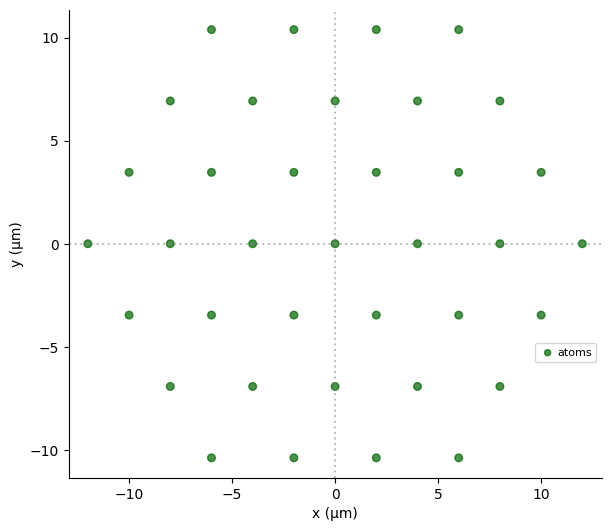

In [20]:
layers = 3
reg = pulser.Register.hexagon(layers)
reg.draw(with_labels=False)

In fact, we can place the atoms in arbitrary positions by specifying the positions of each one. As an exotic example, here is a picture of the Gioconda (Mona Lisa) as a register of neutral atoms made using Pulser:

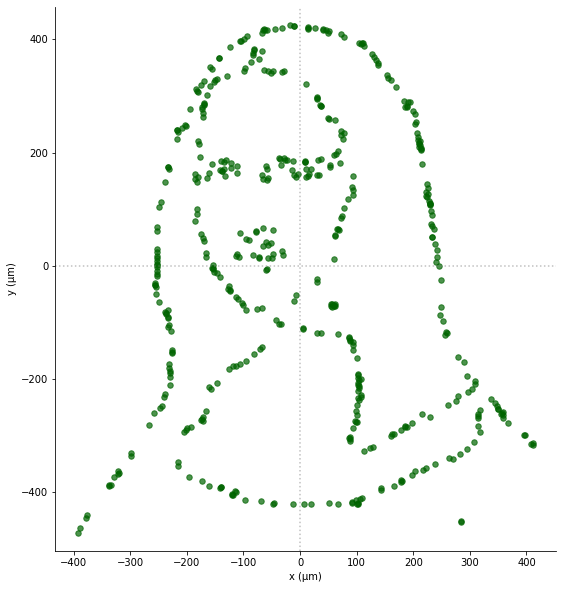

Next we define a ``Pulse`` that will act on the atom array:

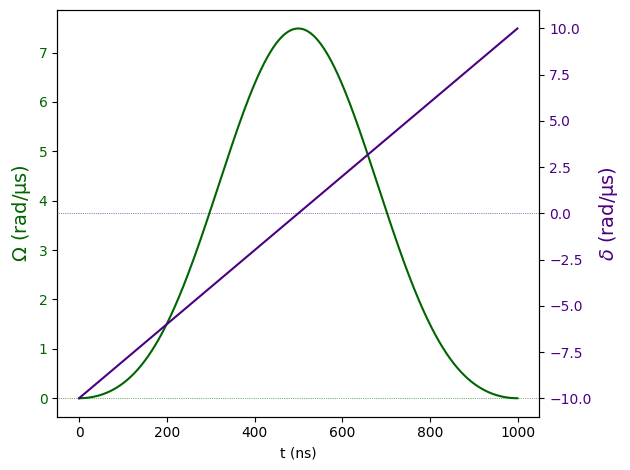

In [21]:
duration = 1000  # Typical: ~1 µsec
pulse = pulser.Pulse(
    amplitude=pulser.waveforms.BlackmanWaveform(duration, np.pi),
    detuning=pulser.waveforms.RampWaveform(duration, -10.0, 10.0),
    phase=0,
)
pulse.draw()

### A simple experiment:

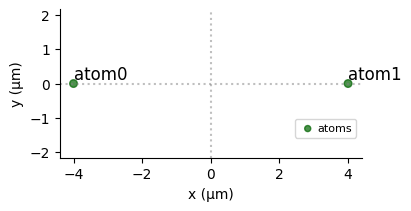

In [22]:
reg = pulser.Register.rectangle(1, 2, spacing=8, prefix="atom")
reg.draw()

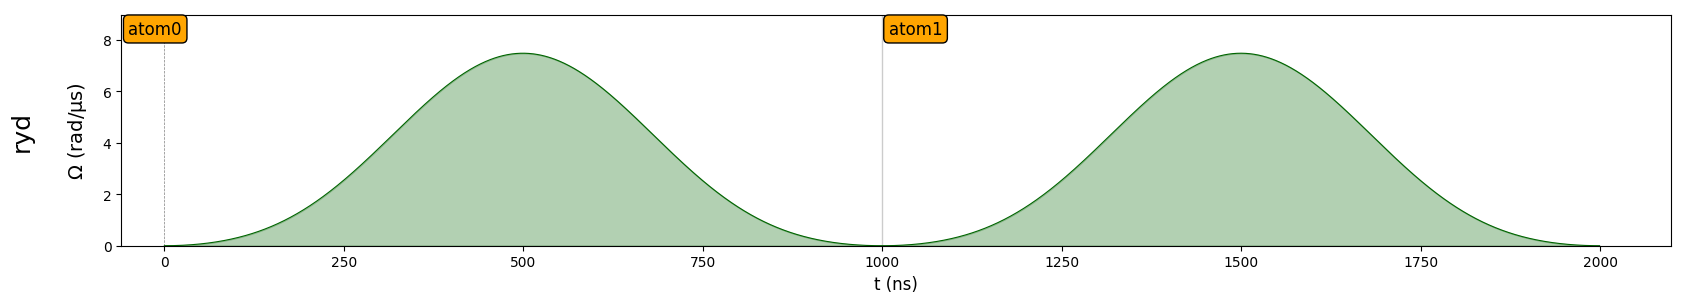

In [16]:
pi_pulse = pulser.Pulse.ConstantDetuning(
    pulser.waveforms.BlackmanWaveform(duration, np.pi), 0.0, 0.0
)

seq = pulser.Sequence(reg, pulser.devices.DigitalAnalogDevice)

seq.declare_channel("ryd", "rydberg_local", "atom0")

seq.add(pi_pulse, "ryd")
seq.target("atom1", "ryd")
seq.add(pi_pulse, "ryd")

seq.draw()

## Probing the Rydberg Blockade Mechanism

The resonant two-atom Hamiltonian:

$$H = \frac{\hbar \Omega_1(t)}{2} \sigma_1^x + \frac{\hbar \Omega_2(t)}{2} \sigma_2^x + U n_1n_2 $$

We shall explore this blockade by calculating the effect on our pulse for various interatomic distances $R$:

In [25]:
data = []
distances = np.linspace(6.5, 14, 7)

r = [1, 0]  # |r>
rr = np.kron(r, r)  # |rr>
occup = [np.outer(rr, np.conj(rr))]  # |rr><rr|

for i, R in enumerate(distances):
    # Atom Register and Device
    reg = pulser.Register.rectangle(1, 2, spacing=R, prefix="atom")

    # Pulse Sequence
    seq = pulser.Sequence(reg, pulser.devices.DigitalAnalogDevice)
    seq.declare_channel("ryd", "rydberg_local", "atom0")
    seq.add(pi_pulse, "ryd")
    seq.target("atom1", "ryd")
    seq.add(pi_pulse, "ryd")

    sim = QutipEmulator.from_sequence(seq)

    res = sim.run()  # Returns a SimulationResults instance
    data.append(
        res.expect(occup)[0]
    )  # Get expectation value for the occupation operator
print("...Simulation Complete!")

...Simulation Complete!


We plot the results:

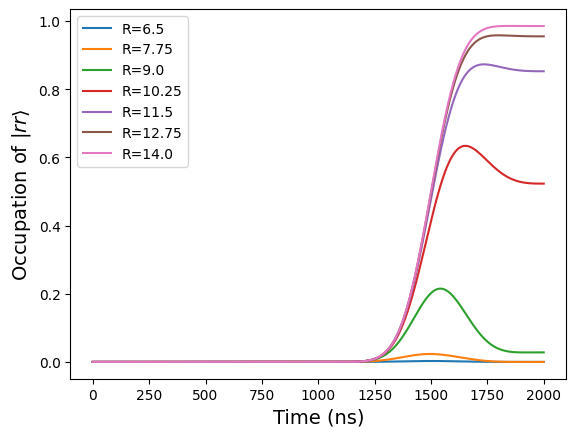

In [26]:
for i, R in enumerate(distances):
    plt.plot(data[i], label=f"R={R}")
    plt.xlabel("Time (ns)", fontsize=14)
    plt.ylabel(r"Occupation of $|rr\rangle$", fontsize=14)
    plt.legend()

Text(0.5, 1.0, 'Excited state fraction at the end of the sequence')

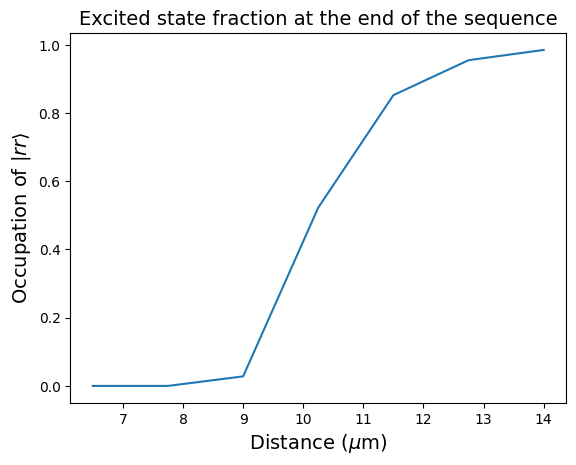

In [27]:
plt.plot(distances, [d[-1] for d in data])
plt.xlabel("Distance ($\mu$m)", fontsize = 14)
plt.ylabel(r"Occupation of $|rr\rangle$", fontsize=14)
plt.title("Excited state fraction at the end of the sequence", fontsize = 14)